In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Load the flattened images and labels
with open('combined_flattened_data.pkl', 'rb') as f_img, open('labels.pkl', 'rb') as f_lbl:
    flattened_images = pickle.load(f_img)
    labels = pickle.load(f_lbl)

num_images = len(flattened_images)
print(num_images)

15


In [2]:
from sklearn.model_selection import train_test_split

# Attach indices to flattened images
indexed_flattened_images = [(i, img) for i, img in enumerate(flattened_images)]

# Split the data into training and testing sets, keeping track of indices
train_indices, test_indices, X_train, X_test, y_train, y_test = train_test_split(
    [t[0] for t in indexed_flattened_images], 
    [t[1] for t in indexed_flattened_images], 
    labels, 
    test_size=0.3, 
    random_state=42
)


In [3]:
# X_train, X_test, y_train, y_test = train_test_split(flattened_images, labels, test_size=0.3, random_state=42)
# print(len(y_test))

In [4]:
# Initialize the SVM model
svm_model = SVC()

# Train the model
svm_model.fit(X_train, y_train)

SVC()

In [5]:
# Predict labels for the test set
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

print(y_pred)
print(y_test)


Model Accuracy: 1.0
[1 2 0 2 1]
[1 2 0 2 1]


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    plt.show()

In [7]:
# Load the original point clouds and labels
with open('shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

# Extract just the point clouds (assuming the first element of each tuple is the point cloud)
original_point_clouds = [pc[0] for pc in original_shape_data]

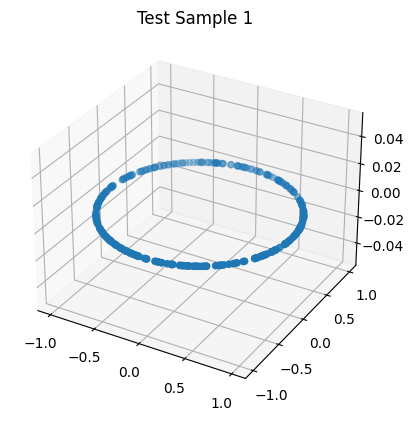

Test Sample 1 - Predicted Class: circle


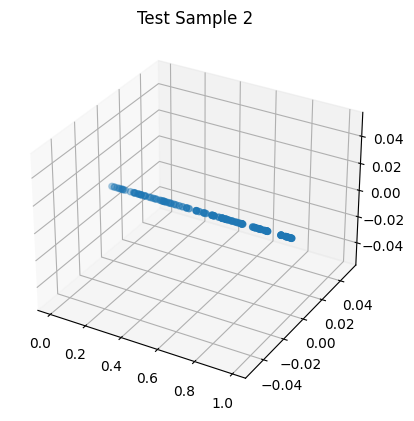

Test Sample 2 - Predicted Class: line_segment


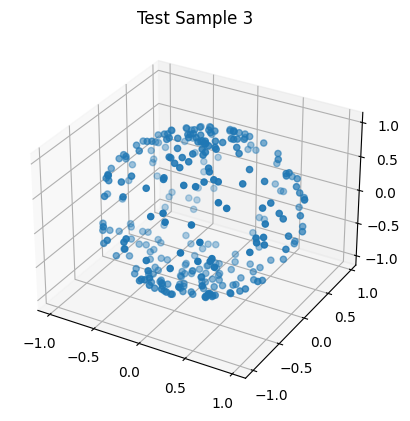

Test Sample 3 - Predicted Class: sphere


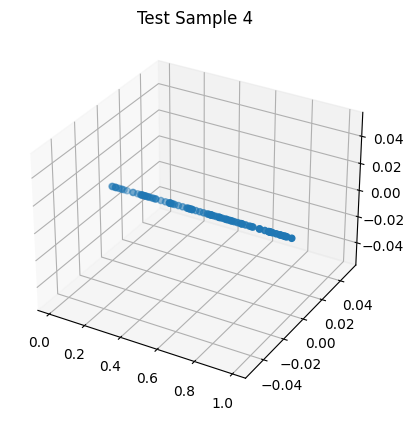

Test Sample 4 - Predicted Class: line_segment


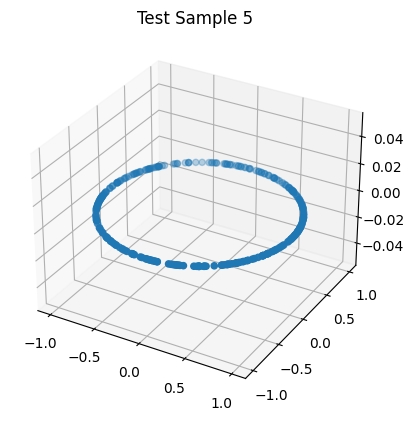

Test Sample 5 - Predicted Class: circle


In [8]:
# ... [Previous code to load flattened images, labels, train SVM, etc.]

# Create a mapping from label numbers to shape names
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment'}  # Adjust based on your label assignments

# Load the original point clouds for visualization
with open('Shape_detection/shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

original_point_clouds = [pc[0] for pc in original_shape_data]

# Choose a few test samples to visualize and predict
num_samples_to_visualize = min(6, len(X_test))
for i in range(num_samples_to_visualize):
    # Get the original point cloud using the test index
    test_point_cloud = original_point_clouds[test_indices[i]]

    # Plot the point cloud
    plot_point_cloud(test_point_cloud, title=f"Test Sample {i+1}")

    # Print the prediction
    predicted_label = svm_model.predict([X_test[i]])[0]
    predicted_shape = shape_names[predicted_label]
    print(f"Test Sample {i+1} - Predicted Class: {predicted_shape}")


## Checking svm quality

In [9]:
import numpy as np

def create_noisy_circle(num_points, radius):
    """
    Create a noisy circle with a given number of points and radius.
    """
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    noise = np.random.normal(0, 0.1, num_points)  # Adjust noise level as needed
    x = (radius + noise) * np.cos(theta)
    y = (radius + noise) * np.sin(theta)
    z = np.zeros(num_points)
    return np.column_stack((x, y, z))

# Example: Create a noisy circle with different sizes and number of points
noisy_circles = [create_noisy_circle(num_points=np.random.randint(200, 400), radius=np.random.uniform(0.8, 1.2)) for _ in range(5)]


In [10]:
def process_shapes_to_persistence_images(shape_data):
    """
    Process a list of shapes to compute their persistence diagrams and images,
    and then flatten these images for SVM.

    Args:
    shape_data (list of tuples): Each tuple contains (point cloud, label).

    Returns:
    Tuple of (flattened_images, labels)
    """
    from gtda.homology import VietorisRipsPersistence
    from gtda.diagrams import PersistenceImage
    import numpy as np

    # Initialize VietorisRipsPersistence
    homology_dimensions = [0, 1, 2]
    persistence = VietorisRipsPersistence(metric="euclidean",
                                          homology_dimensions=homology_dimensions,
                                          n_jobs=6,
                                          collapse_edges=True)

    # Initialize the PersistenceImage transformer
    persistence_image = PersistenceImage(n_bins=50, weight_function=lambda x: x[1])

    # Process each shape
    flattened_images = []
    for i, (point_cloud) in enumerate(shape_data):
        # Reshape for Giotto-tda
        X = point_cloud.reshape(1, *point_cloud.shape)

        # Compute the persistence diagrams
        diagrams = persistence.fit_transform(X)

        # Transform the persistence diagrams to persistence images
        images = persistence_image.fit_transform(diagrams)

        # Flatten the images
        flattened_image = images.reshape(images.shape[0], -1)

        # Collect the results
        flattened_images.append(flattened_image[0])  # [0] to remove the extra dimension

        # Print progress every 5 shapes
        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1} shapes.")

    # Convert to numpy arrays
    flattened_images = np.array(flattened_images)

    return flattened_images

# Example usage:
# shape_data = [(point_cloud1, label1), (point_cloud2, label2), ...]
# flattened_images, labels = process_shapes_to_persistence_images(shape_data)


In [11]:
flim=process_shapes_to_persistence_images(noisy_circles)

Processed 5 shapes.


In [12]:
y_pred_flim = svm_model.predict(flim)

In [13]:
y_pred_flim

array([1, 0, 0, 0, 1])

## Take sth

In [6]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
def plot_point_cloud(point_cloud, ax, title="Point Cloud"):
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

In [8]:
# Load the combined flattened images, labels, and original point clouds
with open('Data/combined_flattened_data_with_indices.pkl', 'rb') as f_img:
    combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
indices, combined_vectors, labels = zip(*combined_flattened_data)

# Convert to numpy arrays
combined_vectors = np.array(combined_vectors)
labels = np.array(labels)

# Load the original point clouds for visualization
with open('Data/shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

In [9]:
# Train-test split with stratification
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    combined_vectors, labels, indices, test_size=0.3, random_state=42, stratify=labels
)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()

Accuracy: 1.00
Test Sample 1 - Predicted Class: line_segment
Test Sample 2 - Predicted Class: circle
Test Sample 3 - Predicted Class: sphere
Test Sample 4 - Predicted Class: line_segment
Test Sample 5 - Predicted Class: circle


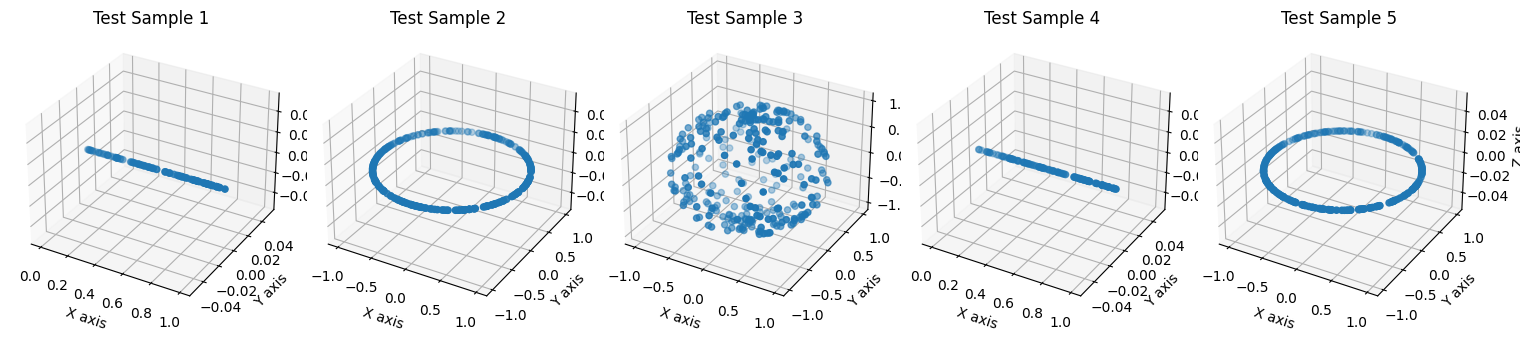

In [10]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Visualize a few test samples and their predictions
num_samples_to_visualize = 5
fig = plt.figure(figsize=(15, 10))

# Create a mapping from label numbers to shape names
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment'}  # Adjust based on your label assignments

for i in range(num_samples_to_visualize):
    # Get the original point cloud index from the test set
    original_index = idx_test[i]
    test_point_cloud = next(pc for idx, pc, _ in original_shape_data if idx == original_index)

    # Plot the point cloud
    ax = fig.add_subplot(2, num_samples_to_visualize, i + 1, projection='3d')
    plot_point_cloud(test_point_cloud, ax, title=f"Test Sample {i+1}")

    # Print the prediction
    predicted_label = y_pred[i]
    predicted_shape = shape_names[predicted_label]
    print(f"Test Sample {i+1} - Predicted Class: {predicted_shape}")

plt.tight_layout()
plt.show()